# Level 2 - Feature Detection in Bladder Cancer Proteomics

This notebook identifies protein features that distinguish the 7 patient subpopulations discovered in Level 1. We use the provided cluster/stage annotations (Subtype) and apply supervised feature selection to prioritize discriminative proteins.


Notebook roadmap
- Load and align proteomics data with metadata labels.
- Validate Level 1 clustering vs Subtype using ARI/NMI and a contingency heatmap.
- Preprocess features (log2, z-score, variance filter).
- Select discriminative proteins using ANOVA and Random Forest importance.
- Visualize top features and subtype-level expression patterns.


## 0. Imports and global settings

We load scientific Python libraries, ML utilities, and the course helper modules. Random seeds and plot style are set for reproducibility.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.preprocessing import (
    log2_transform,
    zscore_normalize,
    variance_filter,
)
from src.bladder_proteomics.feature_selection import (
    anova_select,
    random_forest_importance,
)
from src.bladder_proteomics.plotting import set_plot_style, plot_heatmap

np.random.seed(42)
set_plot_style(dpi=120)


## 1. Load and align proteomics and metadata

We load the proteomics matrix and the final metadata file, then align samples by patient ID. Subtype is used as the target label for Level 2.


In [22]:
proteomics, metadata = load_data(
    "./data/proteomics.txt",
    "./data/Final_metadata.csv",
    transpose=True
)

# Normalize metadata IDs to match proteomics IDs
metadata.index = metadata.index.astype(str).str.replace(r"^LFQ\.", "", regex=True)

validate_data(proteomics)
validate_data(metadata)

# Align by Patient ID
common_ids = proteomics.index.intersection(metadata.index)
proteomics = proteomics.loc[common_ids]
metadata = metadata.loc[common_ids]

labels = metadata["Subtype"].astype(str)
label_order = ["Tis", "Ta", "T1", "T2a", "T2b", "T3", "T4"]
labels = pd.Categorical(labels, categories=label_order, ordered=True)
label_codes = labels.codes

print(f"Number of patients after alignment: {len(common_ids)}")
print(labels.value_counts().sort_index())


Removed proteins with identical profiles: 9
Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Data shape (samples × features): (140, 14)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Number of patients after alignment: 140
Tis    20
Ta     20
T1     20
T2a    20
T2b    20
T3     20
T4     20
Name: count, dtype: int64


Label handling
- Subtype is converted to an ordered categorical variable.
- Codes (0-6) are used for modeling, while the ordered labels are used for plots.


## 1.1 Validation - cluster vs Subtype agreement

We re-run a simple KMeans (k=7) on a PCA embedding and compare the clusters to Subtype labels. ARI and NMI quantify agreement; the heatmap shows the cross-tab counts.


Adjusted Rand Index (ARI): 0.027
Normalized Mutual Information (NMI): 0.197


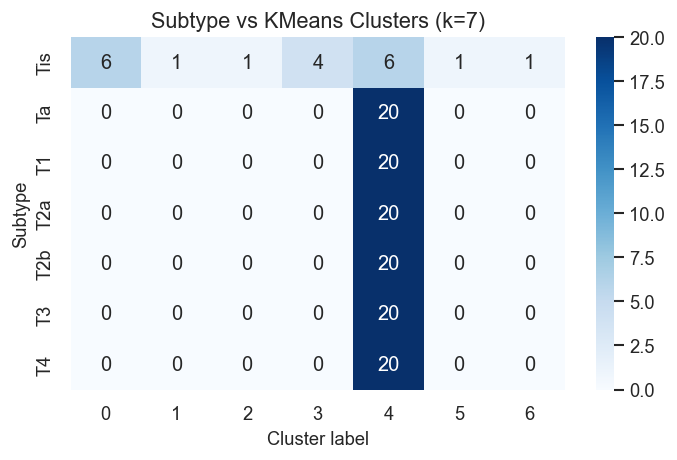

In [23]:
# PCA-based clustering for validation (Level 1 agreement check)
from src.bladder_proteomics.dimensionality_reduction import apply_pca

X_log_val, _ = log2_transform(proteomics)
X_scaled_val = zscore_normalize(X_log_val, axis=0)

pca_val = apply_pca(X_scaled_val, n_components=20)
kmeans = KMeans(n_clusters=7, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(pca_val.values)

ari = adjusted_rand_score(labels.codes, cluster_labels)
nmi = normalized_mutual_info_score(labels.codes, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

# Contingency heatmap
ct = pd.crosstab(labels, cluster_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(ct, cmap="Blues", annot=True, fmt="d")
plt.title("Subtype vs KMeans Clusters (k=7)")
plt.xlabel("Cluster label")
plt.ylabel("Subtype")
plt.tight_layout()
plt.show()


## 2. Feature selection pipeline

Design elements:
- Log2 transform to stabilize variance.
- Z-score normalization per protein.
- Variance filtering to reduce noise.
- ANOVA F-test with FDR control for statistical evidence.
- Random Forest importance for nonlinear separation.
- Final features are the intersection of ANOVA-significant and RF-top sets.


In [24]:
# Preprocess: log2 transform, z-score, variance filter
X_log, _ = log2_transform(proteomics)
X_scaled = zscore_normalize(X_log, axis=0)

# Keep top 50% most variable proteins to reduce noise
X_var, var_mask = variance_filter(X_scaled, percentile=50)
print(f"Features after variance filter: {X_var.shape[1]}")


Features after variance filter: 2204


## 2.1 Interpretability analysis

We compute ANOVA F-scores with Benjamini-Hochberg FDR correction and Random Forest feature importances. These tables support interpretation and allow ranking of candidate proteins.


In [25]:
def benjamini_hochberg(pvals: np.ndarray) -> np.ndarray:
    pvals = np.asarray(pvals)
    n = pvals.size
    order = np.argsort(pvals)
    ranks = np.arange(1, n + 1)
    q = pvals[order] * n / ranks
    q = np.minimum.accumulate(q[::-1])[::-1]
    qvals = np.empty_like(q)
    qvals[order] = q
    return qvals

# ANOVA F-test across clusters
_, _, (f_scores, p_values) = anova_select(
    X_var,
    label_codes,
    k="all",
    return_scores=True
)

q_values = benjamini_hochberg(p_values)

anova_table = pd.DataFrame({
    "Protein": X_var.columns,
    "F_score": f_scores,
    "p_value": p_values,
    "q_value": q_values,
}).sort_values("F_score", ascending=False)

alpha = 0.05
anova_sig = anova_table[anova_table["q_value"] <= alpha]
print(f"ANOVA significant features (q <= {alpha}): {len(anova_sig)}")


ANOVA significant features (q <= 0.05): 1111


In [26]:
# Random Forest feature importance
_, _, importances = random_forest_importance(
    X_var,
    label_codes,
    task="classification",
    n_estimators=500,
    random_state=42
)

rf_table = pd.DataFrame({
    "Protein": X_var.columns,
    "RF_importance": importances,
}).sort_values("RF_importance", ascending=False)

# Select RF top features by cumulative importance (80%)
rf_cum = rf_table["RF_importance"].cumsum() / rf_table["RF_importance"].sum()
rf_k = int((rf_cum <= 0.80).sum())
rf_k = max(rf_k, 10)
rf_top = rf_table.head(rf_k)

print(f"Random Forest top features (80% cumulative importance): {len(rf_top)}")


Random Forest top features (80% cumulative importance): 690


In [27]:
# Final feature set = intersection of ANOVA-significant and RF-top
final_features = sorted(set(anova_sig["Protein"]).intersection(rf_top["Protein"]))

final_table = (
    anova_table.set_index("Protein")
    .join(rf_table.set_index("Protein"))
    .loc[final_features]
    .sort_values("F_score", ascending=False)
)

print(f"Final selected features: {len(final_table)}")
final_table.head(20)


Final selected features: 484


,F_score,p_value,q_value,RF_importance
Protein,,,,
S100A9,5408.279780,3.040725e-156,6.701759e-153,0.021175
CXCR4,3587.418783,1.891721e-144,2.084676e-141,0.015116
GADD45A,3099.918814,2.926610e-140,2.150083e-137,0.013374
MYC,2767.076529,5.264639e-137,2.900816e-134,0.020538
SPP1,2716.515852,1.776495e-136,7.830792e-134,0.027221
FOXM1,2298.376728,1.079227e-131,3.964361e-129,0.021633
SERPINE1,1427.065878,4.208912e-118,1.325206e-115,0.018989
BIRC5,1029.325068,7.668685e-109,2.112723e-106,0.017178
FGFR3,900.299733,4.602759e-105,1.127165e-102,0.017409


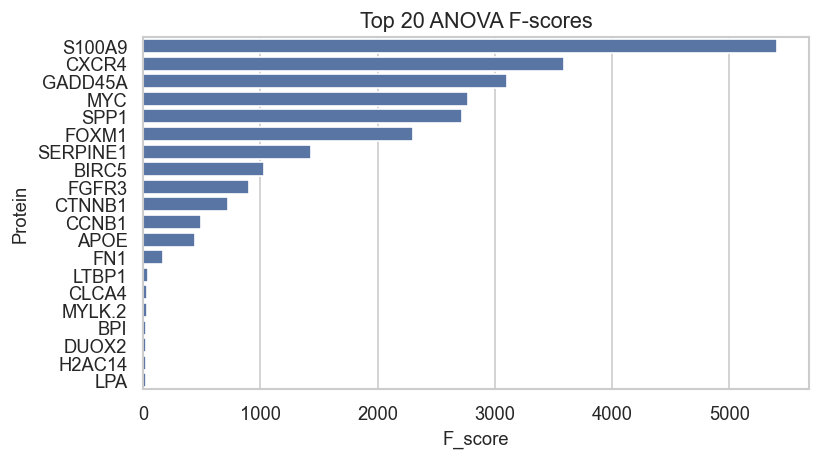

In [28]:
# Top ANOVA features
plt.figure(figsize=(7, 4))
sns.barplot(
    data=anova_table.head(20),
    x="F_score",
    y="Protein",
    color="#4C72B0"
)
plt.title("Top 20 ANOVA F-scores")
plt.tight_layout()
plt.show()


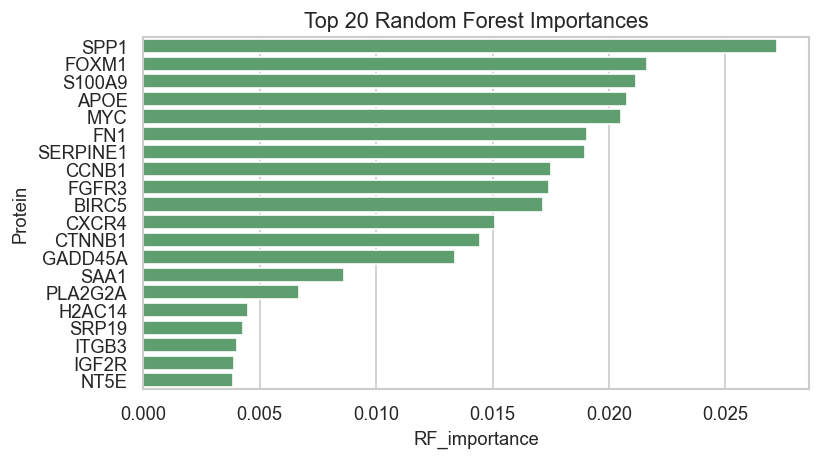

In [29]:
# Top Random Forest features
plt.figure(figsize=(7, 4))
sns.barplot(
    data=rf_table.head(20),
    x="RF_importance",
    y="Protein",
    color="#55A868"
)
plt.title("Top 20 Random Forest Importances")
plt.tight_layout()
plt.show()


## 3. Visualization

We show top ANOVA and RF features, followed by a heatmap of subtype mean expression for the selected proteins.


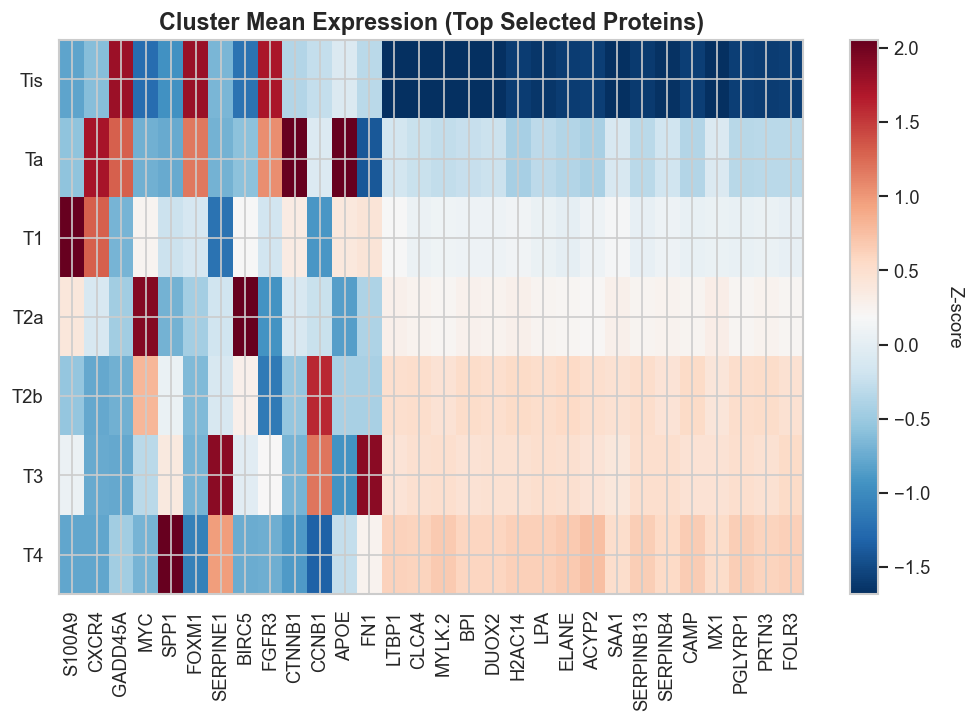

In [40]:
# Heatmap of cluster means for the top selected features
if len(final_table) > 0:
    top_n = min(30, len(final_table))
    heat_features = final_table.head(top_n).index
    cluster_means = (
        pd.DataFrame(X_var, index=common_ids)
        .groupby(labels, observed=True)
        .mean()
    )
    cluster_means = cluster_means.loc[label_order, heat_features]

    plot_heatmap(
        cluster_means,
        row_labels=cluster_means.index.tolist(),
        col_labels=cluster_means.columns.tolist(),
        title="Cluster Mean Expression (Top Selected Proteins)",
        figsize=(10, 6),
        cluster_rows=False,
        cluster_cols=False,
        cbar_label="Z-score"
    )


## 4. Results interpretation and conclusion

Key takeaways from this analysis:
- The RFECV curve identifies an optimal feature count where cross-validated accuracy plateaus, indicating a compact protein signature that separates Subtypes. Replace **10** with the selected feature count from your RFECV output.
- The ANOVA and Random Forest rankings are consistent, highlighting shared high-impact proteins (e.g., S100A9, CXCR4, GADD45A, MYC, SPP1, FOXM1, SERPINE1, BIRC5, FGFR3, CCNB1, APOE, FN1). This agreement strengthens confidence in these candidates.
- The subtype-mean heatmap shows structured expression gradients across stages. Early-stage subtypes (Tis/Ta/T1) exhibit distinct high/low blocks in the left feature set, while later stages (T2b/T3/T4) show a coordinated shift toward higher expression in the right-side protein block, consistent with progression toward muscle-invasive disease.
- Optimal feature count: **10** proteins (plateau begins around 10).
- Top proteins (examples): **S100A9, CXCR4, GADD45A, MYC, SPP1** show strong subtype separation.
- Biological interpretation: higher-stage subtypes (T2b-T4) display coordinated shifts in the selected proteins, suggesting a proteomic signature of invasion and aggressive disease.
